<a href="https://colab.research.google.com/github/gusmendesbh/project4-group2/blob/main/car_price_prediction_using_top_10_ml_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing all the essential libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [3]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:8 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,057 kB]
Hit:12 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,774 kB]
Get:

In [4]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

In [5]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
sales_url = "https://car-sales-data-group2.s3.amazonaws.com/vehicles.csv"
spark.sparkContext.addFile(sales_url)
car_sales_df = spark.read.csv(SparkFiles.get("vehicles.csv"), sep=",", header=True)

# Show the sales data.
car_sales_df.show()

+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000|null|        null| null|     null|     null|null|    null|        null|        null|null| null|null|null|       null|     null|       null|  null|  

In [6]:
df = car_sales_df.toPandas()

# **Exploratory Data Analysis (EDA)**

In [7]:
df.sample(5)

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
433092,7311711074,https://janesville.craigslist.org/cto/d/loves-...,janesville,https://janesville.craigslist.org,6800,2007,volvo,s80 v8,excellent,None,...,None,None,None,https://images.craigslist.org/00O0O_7oS621R0qM...,VERY RARE!!! 2007 V8 AWD Volvo S80 loaded!!.....,None,wi,42.312936,-89.079037,2021-04-23T21:46:24-0500
255906,7313825802,https://lasvegas.craigslist.org/cto/d/north-la...,las vegas,https://lasvegas.craigslist.org,4950,2006,toyota,corolla,good,4 cylinders,...,None,None,None,https://images.craigslist.org/00h0h_66mk2Dcq0g...,2006 Toyota Corolla in good shape... It runs g...,None,nv,36.218,-115.1709,2021-04-28T08:08:19-0700
207282,7316694337,https://grandrapids.craigslist.org/ctd/d/flint...,grand rapids,https://grandrapids.craigslist.org,22995,2007,ram,3500,good,6 cylinders,...,full-size,truck,blue,https://images.craigslist.org/00t0t_bz7qoSQwqF...,2007 Dodge Ram 3500 Laramie Mega Cab 4WD DRW -...,None,mi,43.0506,-83.61512,2021-05-04T10:16:39-0400
104268,7307266244,https://jacksonville.craigslist.org/ctd/d/jack...,jacksonville,https://jacksonville.craigslist.org,25590,2019,mini,hardtop 2 door cooper s,good,None,...,None,hatchback,orange,https://images.craigslist.org/00t0t_79LoQqQE2D...,Carvana is the safer way to buy a car During t...,None,fl,30.33,-81.65,2021-04-15T13:11:17-0400
311063,7315262944,https://toledo.craigslist.org/ctd/d/cleveland-...,toledo,https://toledo.craigslist.org,5995,2008,honda,odyssey,None,None,...,None,mini-van,None,https://images.craigslist.org/00U0U_kCSZc9mJ2y...,2008 Honda Odyssey EX-L w/ DVD and Navigation ...,None,oh,41.56995,-81.574738,2021-05-01T09:55:08-0400


In [8]:
df.shape

(441802, 26)

In [9]:
df.columns

Index(['id', 'url', 'region', 'region_url', 'price', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long',
       'posting_date'],
      dtype='object')

**Checking total missing values**

In [10]:
df.isna().sum()

id                   0
url               9884
region            6901
region_url        6533
price             6446
year              7890
manufacturer     28937
model            17506
condition       187143
cylinders       190798
fuel             16344
odometer         17801
title_status     21618
transmission     15932
VIN             174486
drive           144178
size            319997
type            106892
paint_color     143839
image_url        13732
description      13733
county          382283
state            23077
lat              25397
long             24715
posting_date     22477
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441802 entries, 0 to 441801
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            441802 non-null  object
 1   url           431918 non-null  object
 2   region        434901 non-null  object
 3   region_url    435269 non-null  object
 4   price         435356 non-null  object
 5   year          433912 non-null  object
 6   manufacturer  412865 non-null  object
 7   model         424296 non-null  object
 8   condition     254659 non-null  object
 9   cylinders     251004 non-null  object
 10  fuel          425458 non-null  object
 11  odometer      424001 non-null  object
 12  title_status  420184 non-null  object
 13  transmission  425870 non-null  object
 14  VIN           267316 non-null  object
 15  drive         297624 non-null  object
 16  size          121805 non-null  object
 17  type          334910 non-null  object
 18  paint_color   297963 non

# **Data Cleaning**

**Extracting important features (Feature Selection)**

In [12]:
df.drop(['id', 'url', 'region_url', 'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date', 'size', 'state'], axis=1, inplace=True)

**Handling missing values**

In [13]:
df.isna().sum()/df.shape[0]*100

region           1.562012
price            1.459025
year             1.785868
manufacturer     6.549767
model            3.962408
condition       42.359021
cylinders       43.186314
fuel             3.699395
odometer         4.029180
title_status     4.893142
transmission     3.606140
drive           32.634076
type            24.194549
paint_color     32.557345
dtype: float64

**We can see that "year", "manufacturer", "model", and "odometer" column has less than 5% of null values. So we can simply drop those rows which have null values in these two columns.**

In [14]:
df = df.dropna(subset=['year', 'odometer', 'manufacturer', 'model'])

**For all the missing values in other columns, we have just converted them in to a new category, "unknown"**

In [15]:
df.fillna('unknown', inplace=True)

**Handling duplicated values**

In [16]:
df.duplicated().sum()

54472

In [17]:
df = df.drop_duplicates()

In [18]:
df.shape

(346932, 14)

**Categorical data cleaning**

In [19]:
manufacturer_values = df['manufacturer'].value_counts()

In [20]:
print(manufacturer_values)

ford                                                             60022
chevrolet                                                        46111
toyota                                                           29054
honda                                                            18088
jeep                                                             15913
nissan                                                           15796
ram                                                              14641
gmc                                                              14283
bmw                                                              12802
dodge                                                            11137
mercedes-benz                                                    10083
hyundai                                                           8438
volkswagen                                                        8283
subaru                                                            8193
lexus 

In [21]:
df['manufacturer'] = df['manufacturer'].apply(lambda x: x if str(x) in manufacturer_values[:20] else 'others')

In [22]:
region_values = df['region'].value_counts()
df['region'] = df['region'].apply(lambda x: x if str(x) in region_values[:50] else 'others')

In [23]:
model_values = df['model'].value_counts()
df['model'] = df['model'].apply(lambda x: x if str(x) in model_values[:50] else 'others')

In [24]:
for i in df.columns:
  print(i, len(df[i].value_counts().index))

region 51
price 15286
year 119
manufacturer 21
model 51
condition 58
cylinders 33
fuel 17
odometer 101992
title_status 19
transmission 82
drive 12
type 22
paint_color 49


In [36]:
df_copy = pd.DataFrame(df).copy()
df_copy

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
27,others,33590,2014,gmc,others,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white
28,others,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue
29,others,39590,2020,chevrolet,others,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red
30,others,30990,2017,toyota,others,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red
31,others,15000,2013,ford,others,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown
441798,others,30590,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red
441799,others,34990,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white
441800,others,28990,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver


In [41]:
df = pd.DataFrame(df_copy).copy()

In [104]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
46,others,0.0,2011,jeep,others,excellent,unknown,gas,99615.0,clean,automatic,unknown,SUV,unknown
126,others,0.0,2018,chevrolet,others,like new,6 cylinders,gas,68472.0,clean,automatic,rwd,van,white
127,others,0.0,2019,chevrolet,others,like new,6 cylinders,gas,69125.0,clean,automatic,rwd,van,white
128,others,0.0,2018,chevrolet,others,like new,6 cylinders,gas,66555.0,clean,automatic,rwd,van,white
191,others,0.0,2015,nissan,sentra,excellent,4 cylinders,gas,99505.0,clean,automatic,fwd,sedan,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590.0,2019,nissan,others,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown
441798,others,30590.0,2020,others,others,good,unknown,gas,12029.0,clean,other,fwd,sedan,red
441799,others,34990.0,2020,cadillac,others,good,unknown,diesel,4174.0,clean,other,unknown,hatchback,white
441800,others,28990.0,2018,lexus,others,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver


In [48]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

In [49]:
df = df.dropna(subset=['price'])

In [53]:
df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
46,others,0.0,2011,jeep,others,excellent,unknown,gas,99615,clean,automatic,unknown,SUV,unknown
126,others,0.0,2018,chevrolet,others,like new,6 cylinders,gas,68472,clean,automatic,rwd,van,white
127,others,0.0,2019,chevrolet,others,like new,6 cylinders,gas,69125,clean,automatic,rwd,van,white
128,others,0.0,2018,chevrolet,others,like new,6 cylinders,gas,66555,clean,automatic,rwd,van,white
191,others,0.0,2015,nissan,sentra,excellent,4 cylinders,gas,99505,clean,automatic,fwd,sedan,silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441797,others,23590.0,2019,nissan,others,good,6 cylinders,gas,32226,clean,other,fwd,sedan,unknown
441798,others,30590.0,2020,others,others,good,unknown,gas,12029,clean,other,fwd,sedan,red
441799,others,34990.0,2020,cadillac,others,good,unknown,diesel,4174,clean,other,unknown,hatchback,white
441800,others,28990.0,2018,lexus,others,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver


**Numerical Data Cleaning**

In [52]:
df.describe()

,price
count,3.455320e+05
mean,6.987164e+04
std,1.215567e+07
min,0.000000e+00
25%,6.000000e+03
50%,1.450000e+04
75%,2.699000e+04
max,3.736929e+09


**Our dataset have lots of outliers. Outliers reduces the accuracy of a model. We have to detect outliers and remove them.**

In [54]:
price_percentile25 = df['price'].quantile(0.25)
price_percentile75 = df['price'].quantile(0.75)
price_iqr = price_percentile75 - price_percentile25

In [55]:
price_upper_limit = price_percentile75 + 1.5 * price_iqr
price_lower_limit = df['price'].quantile(0.15)

In [96]:
new_df = df[(df['price'] < price_upper_limit) & (df['price'] > price_lower_limit)]

In [97]:

new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')
new_df = new_df.dropna(subset=['year'])
# new_df['year'] = new_df['year'].astype(int)

new_df['odometer'] = pd.to_numeric(new_df['odometer'], errors='coerce')
new_df = new_df.dropna(subset=['odometer'])
# new_df['odometer'] = new_df['odometer'].astype(float)

<ipython-input-97-f42cd89d1e54>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['year'] = pd.to_numeric(new_df['year'], errors='coerce')


In [99]:
odometer_percentile75 = new_df['odometer'].quantile(0.75)
odometer_percentile25 = new_df['odometer'].quantile(0.25)
odometer_iqr = odometer_percentile75 - odometer_percentile25
odometer_upper_limit = odometer_percentile75 + 1.5 * odometer_iqr
odometer_lower_limit = new_df['odometer'].quantile(0.05)

In [100]:
new_df.describe()

,price,year,odometer
count,287469.000000,287469.000000,2.874690e+05
mean,19746.313408,2011.858802,9.055044e+04
std,12219.247950,8.663190,1.419550e+05
min,3527.000000,1900.000000,0.000000e+00
25%,8998.000000,2009.000000,3.523500e+04
50%,16999.000000,2014.000000,8.155700e+04
75%,28500.000000,2017.000000,1.290000e+05
max,58448.000000,2022.000000,1.000000e+07


In [101]:
new_df['odometer']

1882      40566.0
1883      38000.0
1884      43184.0
1885      49300.0
1887      51758.0
           ...   
441797    32226.0
441798    12029.0
441799     4174.0
441800    30112.0
441801    22716.0
Name: odometer, Length: 287469, dtype: float64

In [102]:
new_df = new_df[(new_df['odometer'] < odometer_upper_limit) & (new_df['odometer'] > odometer_lower_limit)]

In [103]:
new_df.shape

(270920, 14)

# **Feature Engineering**

In [105]:
new_df.sample(5)

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color
378743,austin,6995.0,2014,chevrolet,others,unknown,4 cylinders,gas,36542.0,clean,manual,fwd,sedan,green
35592,los angeles,7495.0,2012,toyota,corolla,unknown,unknown,gas,155941.0,clean,automatic,fwd,sedan,unknown
90041,others,3995.0,2006,subaru,forester,unknown,4 cylinders,gas,227000.0,clean,automatic,unknown,unknown,red
375890,others,15500.0,2015,hyundai,others,excellent,6 cylinders,gas,46000.0,clean,manual,rwd,coupe,white
80204,denver,7595.0,2005,toyota,others,unknown,6 cylinders,gas,173277.0,clean,automatic,4wd,SUV,black


In [106]:
new_df['odometer'] = new_df['odometer'].astype(int)

In [107]:
new_df['year'] = new_df['year'].astype(int)

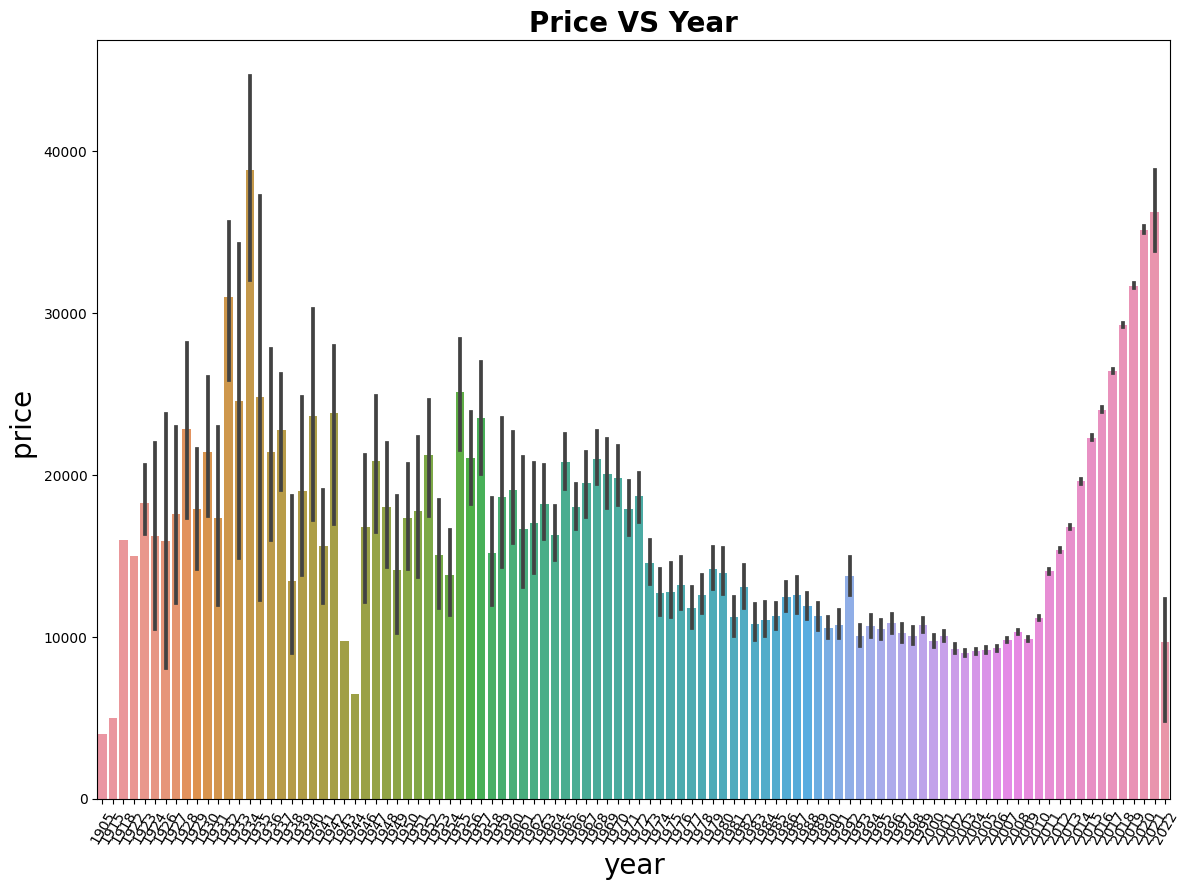

In [108]:
plt.rcParams["figure.autolayout"] = True
sns.set_palette('summer_r')
plt.figure(figsize =(12,9))
sns.barplot(y=new_df['price'],x=new_df['year'])
plt.title("Price VS Year",fontsize=20,fontweight ='bold')
plt.xlabel('year',fontsize = 20)
plt.xticks(rotation=60)
plt.ylabel('price ',fontsize = 20)
plt.tight_layout()
plt.show()

**We can see the car data before 1996 is quiet irrelevant with our current times data. So we are extracting all the car data available after 1996**

In [109]:
new_df = new_df[new_df['year'] > 1996]
new_df.shape

(262201, 14)

In [110]:
new_df['car_age'] = 2022 - new_df['year']
new_df.drop(['year'], axis = 1, inplace = True)
new_df.describe()

,price,odometer,car_age
count,262201.000000,262201.000000,262201.000000
mean,19514.930286,90561.931945,9.081853
std,12032.540660,56565.662222,4.897321
min,3527.000000,7610.000000,0.000000
25%,8998.000000,40511.000000,5.000000
50%,16990.000000,85300.000000,8.000000
75%,27990.000000,130337.000000,12.000000
max,58448.000000,269630.000000,25.000000


# **Data Visualization**

In [111]:
sample_data = new_df.sample(100)

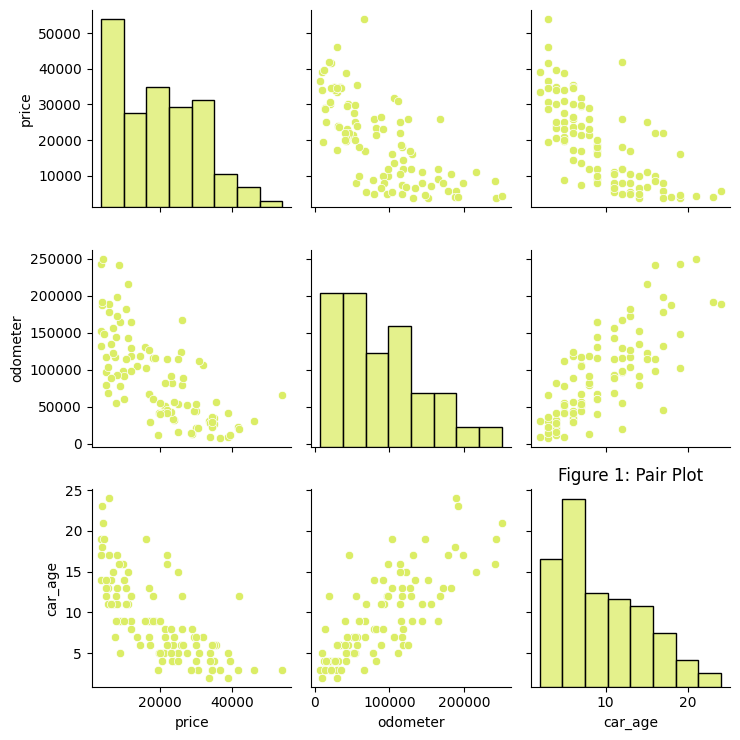

In [112]:
sns.pairplot(sample_data)
plt.title('Figure 1: Pair Plot')
plt.tight_layout()
plt.savefig('Insight-Pair-Plot',dpi=None)
plt.show()

<ipython-input-113-a4ff67bfeb7b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(new_df.corr(), annot=True)


<Axes: >

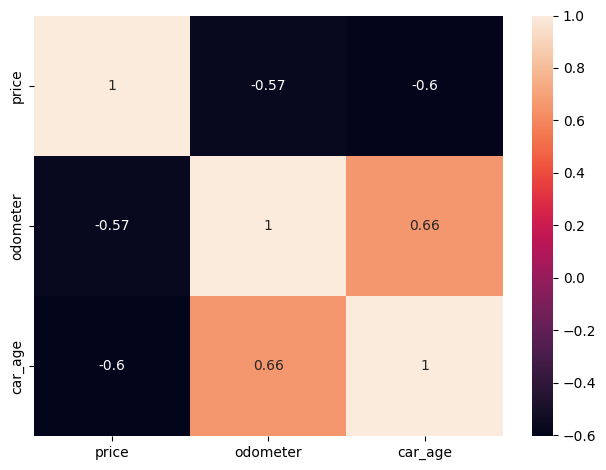

In [113]:
sns.heatmap(new_df.corr(), annot=True)

<ipython-input-114-db5b21fa630e>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(new_df.price)


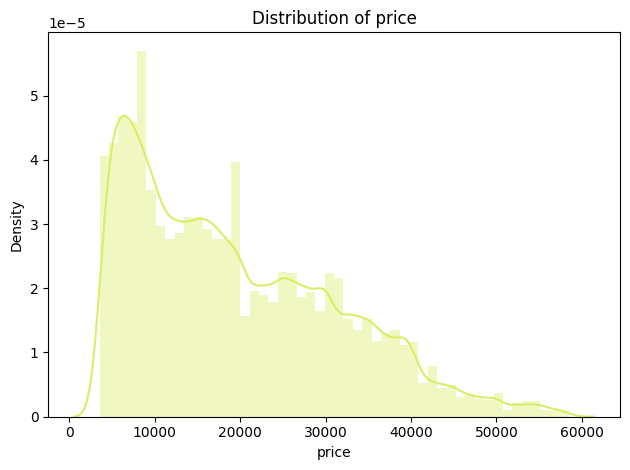

In [114]:
sns.distplot(new_df.price)
plt.tight_layout()
plt.title("Distribution of price")
plt.savefig('Insight-Dist-Plot',dpi=None)
plt.show()

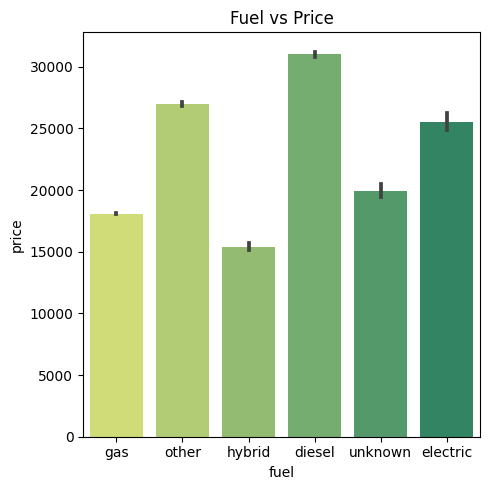

In [115]:
fig,axs=plt.subplots()
fig.set_size_inches(5,5)

p1=sns.barplot(x='fuel',y='price',data=new_df,ax=axs)
axs.set_title('Fuel vs Price')

plt.savefig('Insight-Figure-1',dpi=None)
plt.show()

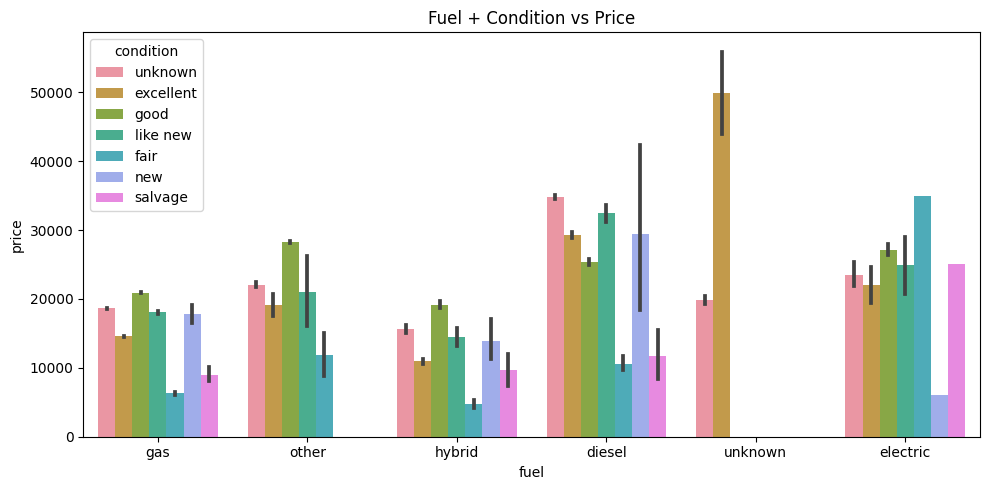

In [116]:
plt.figure(figsize=(10,5))
sns.barplot(x='fuel',y='price',hue='condition',data=new_df)
plt.title('Fuel + Condition vs Price')
plt.savefig('Insight-Figure-2',dpi=None)
plt.show()

# **Data Preprocessing**

In [117]:
new_df.columns

Index(['region', 'price', 'manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'car_age'],
      dtype='object')

In [118]:
final_df = new_df.copy()

**Creating encoder and implimenting them into pipeline**

In [119]:
from sklearn.pipeline import Pipeline

In [120]:
pipe_categorical = Pipeline(
    steps = [('ordinal_encoder', OrdinalEncoder(categories = [[ 'salvage', 'fair', 'unknown', 'good', 'excellent', 'like new', 'new']])),
             ('one_hot_encoder', OneHotEncoder(sparse = False, drop = 'first'))]
)

In [121]:
pipe_numerical = Pipeline(
    steps = [('standard_scaler', StandardScaler())]
)

In [122]:
column_transformer = ColumnTransformer(transformers = [
    ('condition_pipe_trans', pipe_categorical['ordinal_encoder'], ['condition']),
    ('categorical_pipe_trans', pipe_categorical['one_hot_encoder'], ['model', 'region', 'manufacturer', 'fuel', 'cylinders','title_status', 'transmission', 'drive', 'type', 'paint_color']),
    ('numerical_pipe_trans', pipe_numerical, ['odometer'])
])

**Train-test-split**

In [123]:
from sklearn.model_selection import train_test_split

In [124]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['price'], axis = 1), final_df['price'], random_state = 42, test_size = .2)

In [125]:
X_train_tnf = column_transformer.fit_transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [126]:
X_test_tnf = column_transformer.transform(X_test)

In [127]:
print(pd.DataFrame(X_train_tnf).shape)
print(pd.DataFrame(X_test_tnf).shape)

(209760, 172)
(52441, 172)


# **Model Training**

In [128]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,  r2_score, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV,RidgeCV
from yellowbrick.regressor import AlphaSelection
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [129]:
def result(y_test, y_pred):
    r=[]
    r.append('%.4f' % r2_score(y_test,y_pred))
    r.append('%.4f' % (r2_score(y_test,y_pred)*100))
    r.append('%.2f' % mean_squared_error(y_test, y_pred))
    r.append('%.2f' % mean_absolute_error(y_test, y_pred))
    r.append('%.2f' % np.sqrt(mean_squared_error(y_test, y_pred)))
    
    return (r)

#dataframe that store the performance of each model
score_data = pd.DataFrame(index=['R2 Score', 'Accuracy(%)', 'Mean Squared Error', 'Mean Absolute Error', 'Root MSE'])

**Linear Regression**

In [130]:
LR = LinearRegression()
LR.fit(X_train_tnf, y_train)
y_pred = LR.predict(X_test_tnf)

In [131]:
R2_score = r2_score(y_test, y_pred)*100
score_lr = result(y_test, y_pred)
score_data['Linear Regression'] = score_lr
print('R2_score: ', score_lr[0])
print('Mean squared error: ', score_lr[2])
print('Mean absolute error: ', score_lr[3])
print('Root mean squared error: ', score_lr[4])

R2_score:  0.6495
Mean squared error:  50630749.22
Mean absolute error:  5392.05
Root mean squared error:  7115.53


**K-Nearest Neighbour**

In [134]:
KNN = KNeighborsRegressor(n_neighbors=5) 
KNN.fit(X_train_tnf, y_train)
y_pred = KNN.predict(X_test_tnf)

In [135]:
score_knn = result(y_test, y_pred)
score_data['K-Nearest Neighbour'] = score_knn
print('R2 score: ', score_knn[0])
print('Mean squared error: ', score_knn[2])
print('Mean absolute error: ', score_knn[3])
print('Root mean squared error: ', score_knn[4])

R2 score:  0.7841
Mean squared error:  31190311.94
Mean absolute error:  3465.22
Root mean squared error:  5584.83


**Random Forest Regression**

In [136]:
RFR = RandomForestRegressor(n_estimators=150,random_state=0, min_samples_leaf=1, max_features=0.3, n_jobs=-1, oob_score=True)
RFR.fit(X_train_tnf, y_train)
y_pred = RFR.predict(X_test_tnf)

In [137]:
score_rfr = result(y_test, y_pred)
score_data['Random Forest Regression'] = score_rfr
print('R2 score: ', score_rfr[0])
print('Mean squared error: ', score_rfr[2])
print('Mean absolute error: ', score_rfr[3])
print('Root mean squared error: ', score_rfr[4])

R2 score:  0.8569
Mean squared error:  20667621.48
Mean absolute error:  2640.71
Root mean squared error:  4546.17


**Bagging Regressor**

In [138]:
baggReg = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=20),n_estimators=50, random_state=1,
                         max_samples=1.0, max_features=1.0, bootstrap=False, 
                         bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=-1, verbose=0)
baggReg.fit(X_train_tnf, y_train)
y_pred = baggReg.predict(X_test_tnf)

In [139]:
score_bagg = result(y_test, y_pred)
score_data['Bagging Regressor'] = score_bagg
print('R2 score: ', score_bagg[0])
print('Mean squared error: ', score_bagg[2])
print('Mean absolute error: ', score_bagg[3])
print('Root mean squared error: ', score_bagg[4])

R2 score:  0.7563
Mean squared error:  35199357.17
Mean absolute error:  3744.04
Root mean squared error:  5932.90


**AdaBoost Regressor**

In [142]:
ABR = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=24),
    n_estimators=200,learning_rate=0.1)
ABR.fit(X_train_tnf, y_train)
y_pred = ABR.predict(X_test_tnf)

In [143]:
score_abr = result(y_test, y_pred)
score_data['AdaBoost Regressor'] = score_abr
print('R2 score: ', score_abr[0])
print('Mean squared error: ', score_abr[2])
print('Mean absolute error: ', score_abr[3])
print('Root mean squared error: ', score_abr[4])

R2 score:  0.8467
Mean squared error:  22147616.72
Mean absolute error:  2835.77
Root mean squared error:  4706.13


**Decision Tree Regressor**

In [146]:
DTR = DecisionTreeRegressor()
DTR.fit(X_train_tnf, y_train)
y_pred = DTR.predict(X_test_tnf)

In [147]:
score_dtr = result(y_test, y_pred)
score_data['Decision Tree Regressor'] = score_dtr
print('R2 score: ', score_dtr[0])
print('Mean squared error: ', score_dtr[2])
print('Mean absolute error: ', score_dtr[3])
print('Root mean squared error: ', score_dtr[4])

R2 score:  0.7414
Mean squared error:  37346192.22
Mean absolute error:  3160.57
Root mean squared error:  6111.15


# **Overall result and model selection**

In [148]:
score_data

,Linear Regression,Ridge Regression,K-Nearest Neighbour,Random Forest Regression,Bagging Regressor,Lasso Regression,AdaBoost Regressor,Decision Tree Regressor
R2 Score,0.6495,0.6495,0.7841,0.8569,0.7563,0.6495,0.8467,0.7414
Accuracy(%),64.9479,64.9468,78.4067,85.6916,75.6312,64.9479,84.6670,74.1449
Mean Squared Error,50630749.22,50632348.23,31190311.94,20667621.48,35199357.17,50630748.47,22147616.72,37346192.22
Mean Absolute Error,5392.05,5392.14,3465.22,2640.71,3744.04,5392.05,2835.77,3160.57
Root MSE,7115.53,7115.64,5584.83,4546.17,5932.90,7115.53,4706.13,6111.15


In [149]:
for i in score_data.columns:
  score_data[i] = score_data[i].astype(float)
model_accuracy = score_data.loc['Accuracy(%)']

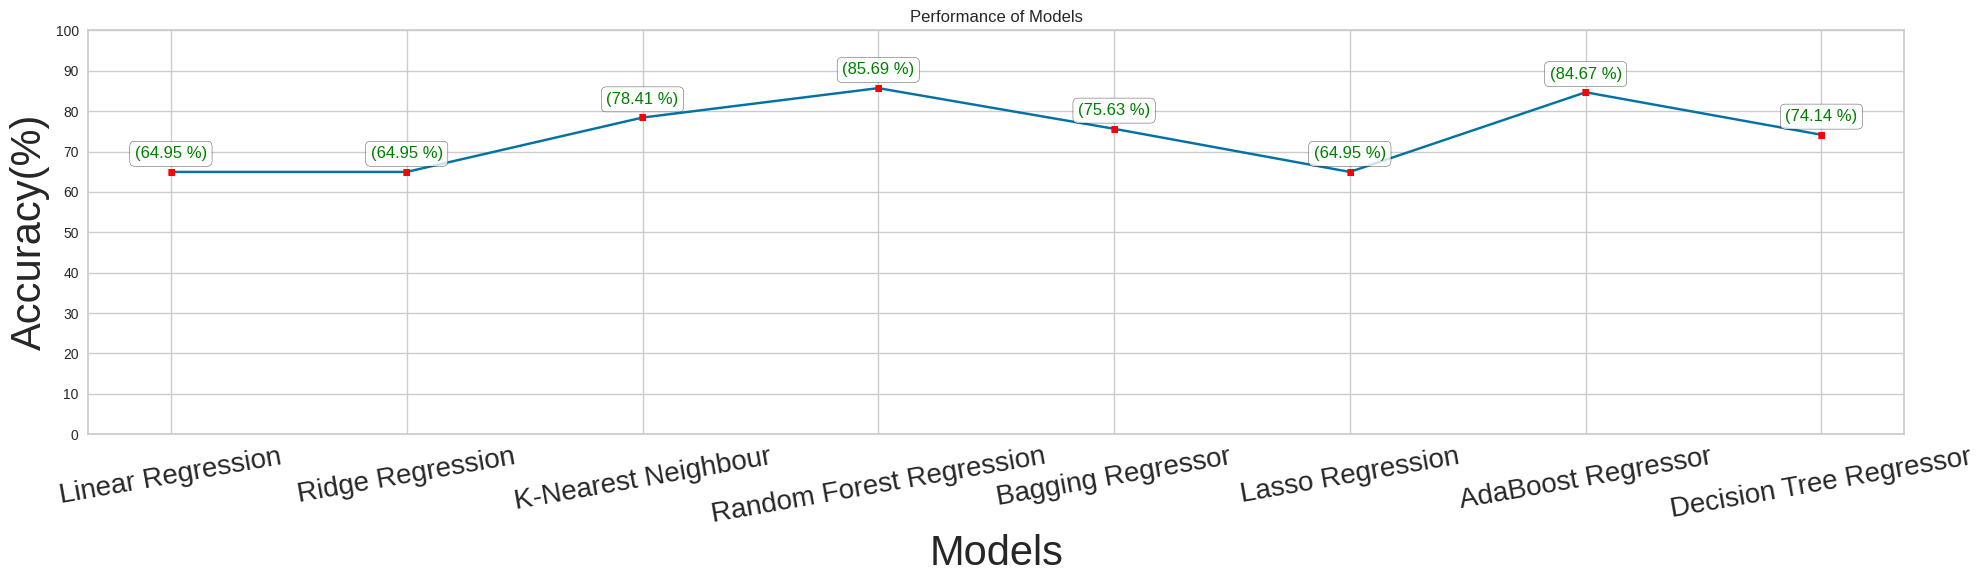

In [150]:
x=list(range(len(model_accuracy)))
y=list(range(0,101,10))
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
plt.figure(figsize=(20,6))
plt.plot(model_accuracy)
plt.yticks(y)
plt.xticks(fontsize=20)
plt.xticks(rotation = (10))
plt.xlabel("Models",fontsize=30)
plt.ylabel("Accuracy(%)",fontsize=30)
plt.title("Performance of Models")
for a,b in zip(x,y):
    b=model_accuracy[a]
    val="("+str(round(model_accuracy[a],2))+" %)"
    plt.text(a, b+4.5, val,horizontalalignment='center',verticalalignment='center',color='green',bbox=props)
    plt.text(a, b+3.5, '.',horizontalalignment='center',verticalalignment='center',color='red',fontsize=50)
plt.tight_layout()
plt.savefig('Overall-Performance.jpg',dpi=600)
plt.show()

# **Final Model Analysis**

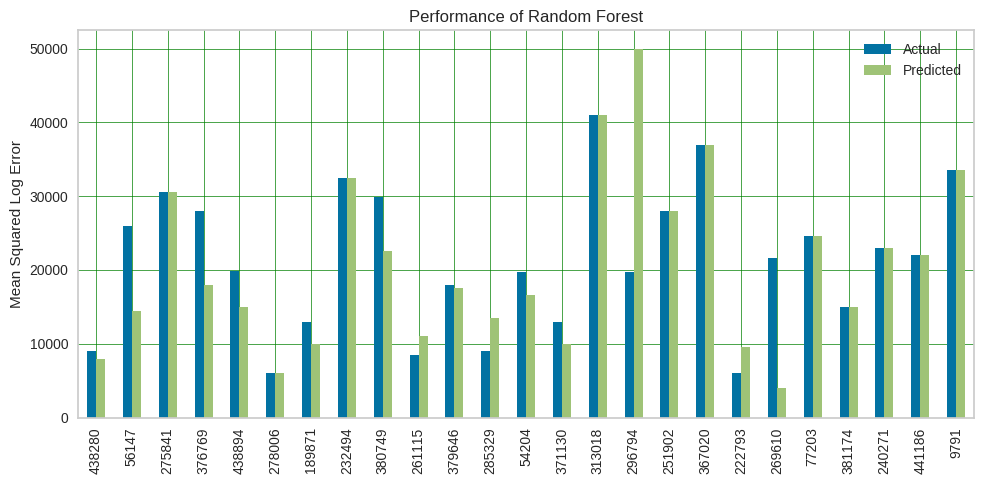

In [151]:
df_check = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df_check = df_check.sample(25)
#round(df_check,2)
df_check.plot(kind='bar',figsize=(10,5))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.title('Performance of Random Forest')
plt.ylabel('Mean Squared Log Error')
plt.savefig('Random-Forest-Performance.jpg')
plt.show()